In [1]:
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import numpy as np
from helper import GeometricBrownianMotion
from ipywidgets import interact, IntSlider


In [2]:
r = 0.02
sigma = 0.15
gbm = GeometricBrownianMotion(mu=r, sigma=sigma)
t = np.linspace(0, 5, 12 * 5)

X = gbm.simulate(t, 50)

X.shape

(60, 50)

In [3]:
def exercise_value(s):
    return np.maximum(1.1 - s, 0)
    
cashflow = exercise_value(X[-1, :]) * np.exp(-r * (t[-2] - t[-1]))
p = Polynomial.fit(X[-2, :], cashflow, 2)
p

Polynomial([-0.08625953, -0.17360718,  0.3585611 ], domain=[0.5197687 , 3.16283403], window=[-1.,  1.])

(-0.08791336286787135, 0.5718020055206748)

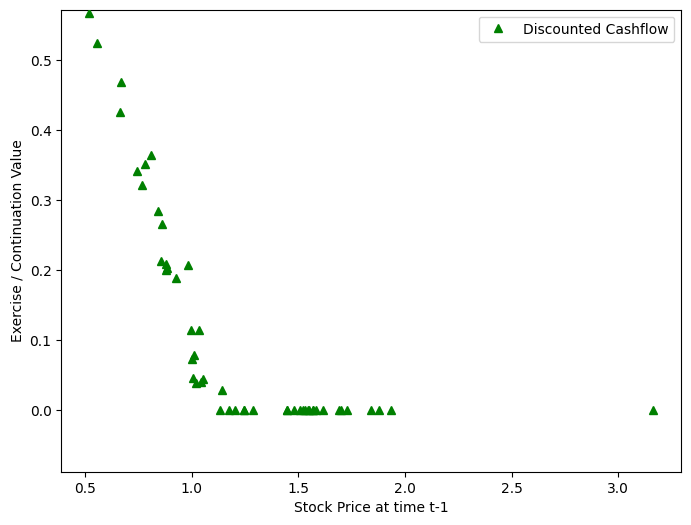

In [4]:
figsize = (8, 6)
plt.figure(figsize=figsize)
plt.plot(X[-2, :], cashflow, "g^", zorder=3)
plt.legend(["Discounted Cashflow"])
plt.xlabel("Stock Price at time t-1")
plt.ylabel("Exercise / Continuation Value")
plt.ylim((-0.08791336286787135, 0.5718020055206748))

Text(0, 0.5, 'Exercise / Continuation Value')

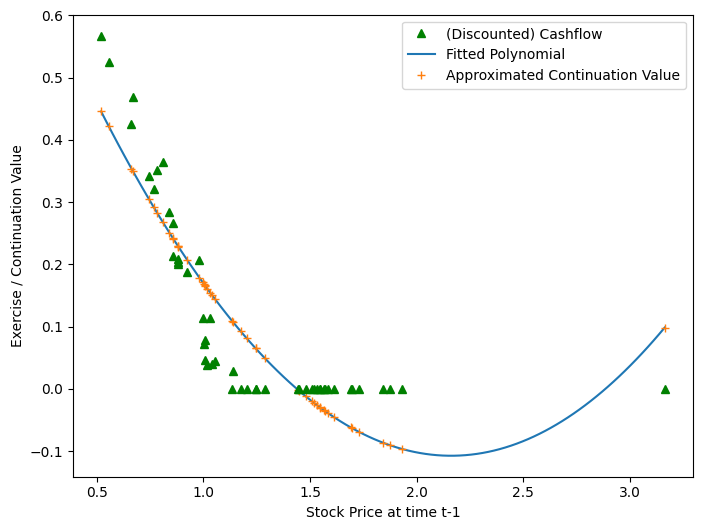

In [5]:
plt.figure(figsize=figsize)
plt.plot(X[-2, :], cashflow, "g^", zorder=3)
plt.plot(*p.linspace(), zorder=1)
plt.plot(X[-2, :], p(X[-2, :]), "+", zorder=2)
plt.legend(
    ["(Discounted) Cashflow", "Fitted Polynomial", "Approximated Continuation Value"]
)
plt.xlabel("Stock Price at time t-1")
plt.ylabel("Exercise / Continuation Value")

In [6]:
stored_res = []

# given no prior exercise we just receive the payoff of a European option
cashflow = exercise_value(X[-1, :])
# iterating backwards in time
for i in reversed(range(1, X.shape[0] - 1)):
    # discount factor between t[i] and t[i+1]
    df = np.exp(-r * (t[i + 1] - t[i]))
    # discount cashflows from next period
    cashflow = cashflow * df
    x = X[i, :]
    # boolean index of all in-the-money paths
    itm = exercise_value(x) > 0
    # fit polynomial of degree 2
    fitted = Polynomial.fit(x[itm], cashflow[itm], 2)
    # approximate continuation value
    continuation = fitted(x)
    # exercise value for time t[i]
    exercise = exercise_value(x)
    # boolean index where exercise is beneficial
    ex_idx = itm & (exercise > continuation)
    # update cashflows with early exercises
    cashflow[ex_idx] = exercise[ex_idx]

    stored_res.append((cashflow, x, fitted, continuation, exercise, ex_idx))

In [7]:
def running_min_max(*array_seq):
    minimum, maximum = None, None
    for a in array_seq:
        cmin, cmax = a.min(), a.max()
        if minimum is None or cmin < minimum:
            minimum = cmin
        if maximum is None or cmax < maximum:
            maximum = cmax
    return minimum, maximum

In [8]:
grey = "#dddddd"


def plot_approx_n(n_steps, ax):
    cashflow, x, fitted, continuation, exercise, ex_idx = stored_res[n_steps]
    fitted_x, fitted_y = fitted.linspace()
    y_min, y_max = running_min_max(cashflow, exercise, fitted_y)
    offset = 0.1 * (y_max - y_min)
    ax.set_ylim((y_min - offset, y_max + offset))
    ax.plot(x, cashflow, "^", color="green", zorder=3)
    ax.plot(x[ex_idx], exercise[ex_idx], "x", color="red", zorder=5)
    ax.plot(x[~ex_idx], exercise[~ex_idx], "x", color=grey, zorder=4)
    ax.plot(fitted_x, fitted_y, zorder=2)
    _x = np.linspace(np.min(x), np.max(x))
    ax.plot(_x, fitted(_x), "--", color=grey, zorder=1)
    ax.legend(
        [
            "(Discounted) Cashflow",
            "Favourable Exercise",
            "Unfavourable Exercise",
            "Approx. of Continuation Value",
            "Out-of-the-money Continuation Value",
        ]
    )

In [9]:
@interact(n_steps=IntSlider(min=0, max=len(stored_res) - 1, value=14))
def step(n_steps):
    fig, ax = plt.subplots()
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    plot_approx_n(n_steps, ax)
    plt.xlabel("Stock Price")
    plt.ylabel("Exercise / Continuation Value")

interactive(children=(IntSlider(value=14, description='n_steps', max=57), Output()), _dom_classes=('widget-int…

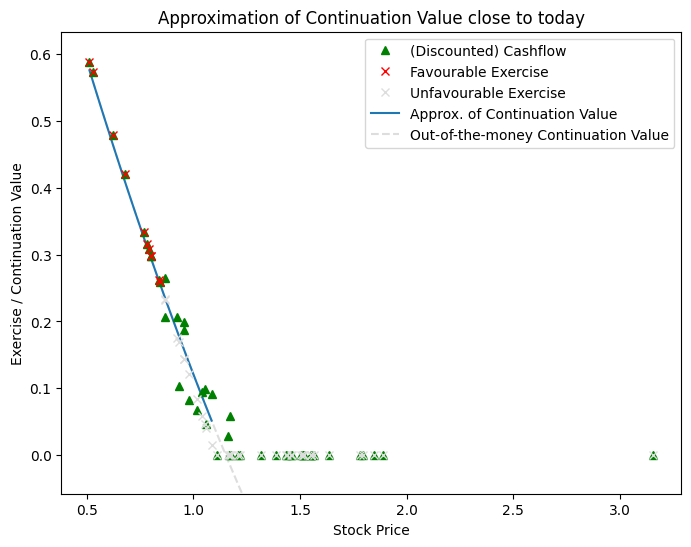

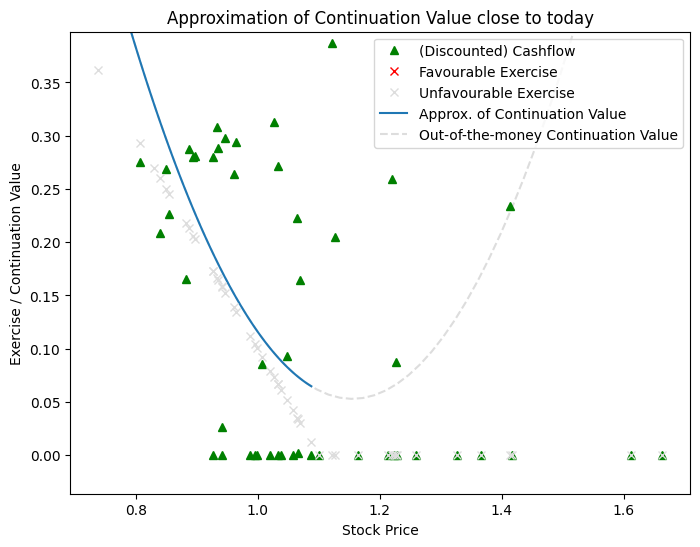

In [10]:
# indices = [0, 1] # [1, 14, 40]
indices = [1, 40]

for n, i in enumerate(indices):
    fig, ax = plt.subplots()
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])
    plot_approx_n(i, ax)
    # ax.set_title(f"Approximation of Continuation Value at t={t[-i-1]:0.2f}")
    ax.set_title(f"Approximation of Continuation Value close to today")
    plt.xlabel("Stock Price")
    plt.ylabel("Exercise / Continuation Value")

Text(0, 0.5, 'Stock Price')

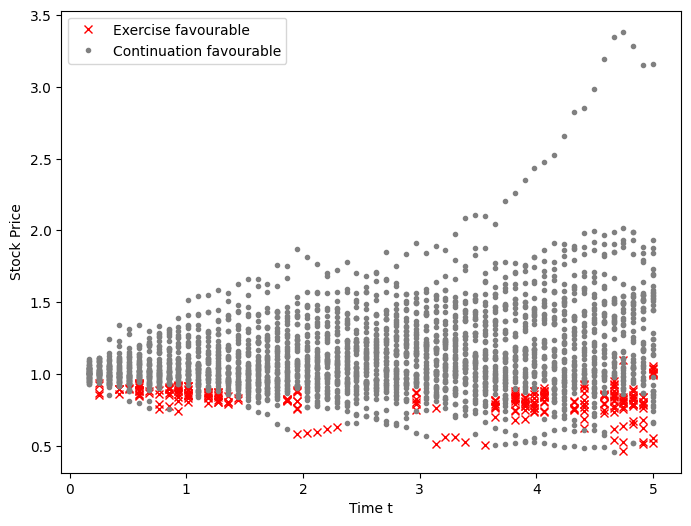

In [11]:
exercise_times = []
exercises = []
non_exercise_times = []
non_exercises = []
for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(
    stored_res
):
    for ex in x[ex_idx]:
        exercise_times.append(t[-i - 1])
        exercises.append(ex)
    for ex in x[~ex_idx]:
        non_exercise_times.append(t[-i - 1])
        non_exercises.append(ex)

plt.figure(figsize=figsize)
plt.plot(exercise_times, exercises, "rx")
plt.plot(non_exercise_times, non_exercises, ".", color="grey")
plt.legend(["Exercise favourable", "Continuation favourable"])
plt.xlabel("Time t")
plt.ylabel("Stock Price")

Text(0, 0.5, 'Stock Price')

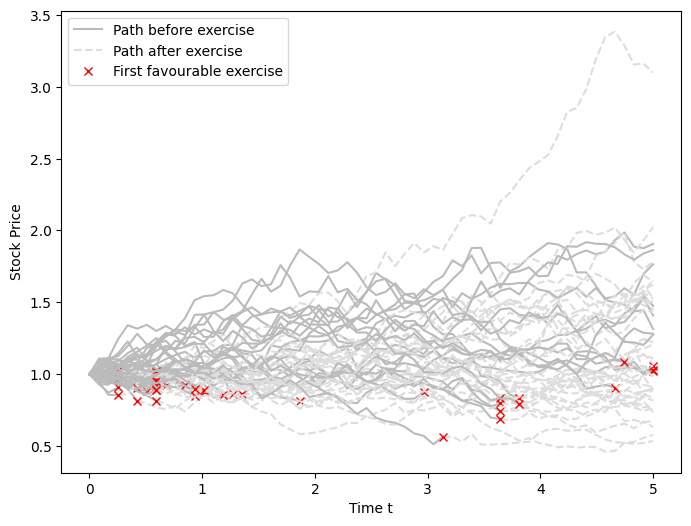

In [12]:
n_timesteps, n_paths = X.shape
first_exercise_idx = n_timesteps * np.ones(shape=(n_paths,), dtype="int")
for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(
    stored_res
):
    for ex in x[ex_idx]:
        idx_now = (n_timesteps - i - 1) * np.ones(shape=(n_paths,), dtype="int")
        first_exercise_idx[ex_idx] = idx_now[ex_idx]

plt.figure(figsize=figsize)
for i in range(n_paths):
    (handle_path,) = plt.plot(
        t[0 : first_exercise_idx[i] + 1],
        X[0 : first_exercise_idx[i] + 1, i],
        "-",
        color="#bbbbbb",
    )
    (handle_stopped_path,) = plt.plot(
        t[first_exercise_idx[i] :], X[first_exercise_idx[i] :, i], "--", color=grey
    )
    if first_exercise_idx[i] < n_timesteps:
        (handle_first_ex,) = plt.plot(
            t[first_exercise_idx[i]], X[first_exercise_idx[i], i], "rx"
        )

plt.legend(
    [handle_path, handle_stopped_path, handle_first_ex],
    ["Path before exercise", "Path after exercise", "First favourable exercise"],
)
plt.xlabel("Time t")
plt.ylabel("Stock Price")

Polynomial([ 0.63820898, -0.15244188,  0.12937815], domain=[0.25423729, 5.        ], window=[-1.,  1.])

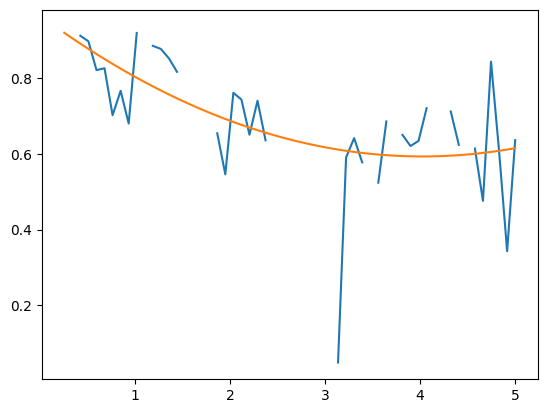

In [13]:
ex_times = []
ex_boundary = []
for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(
    stored_res
):
    fitted = fitted.convert(domain=[-1, 1], window=[-1, 1])
    to_solve = fitted - Polynomial([1.1, -1])
    roots = to_solve.roots()
    roots = [root for root in roots if root <= 1.1 and root >= 0 and root.imag == 0.0]
    if roots:
        ex_boundary.append(min(roots))
    else:
        ex_boundary.append(None)
    ex_times.append(t[-i - 1])

ex_boundary = np.array(ex_boundary, dtype="float")
ex_times = np.array(ex_times)
fitted_boundary = Polynomial.fit(
    ex_times[~np.isnan(ex_boundary)], ex_boundary[~np.isnan(ex_boundary)], 2
)
plt.plot(ex_times, ex_boundary)
plt.plot(*fitted_boundary.linspace())
fitted_boundary

Text(0, 0.5, 'Stock Price')

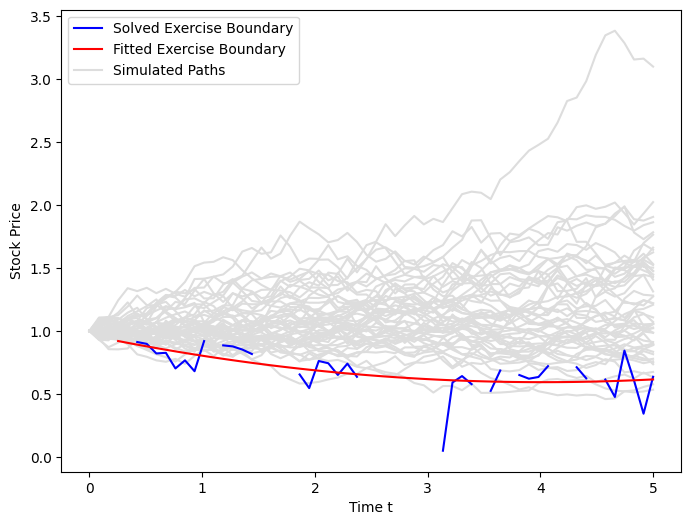

In [14]:
plt.figure(figsize=figsize)
plt.plot(ex_times, ex_boundary, color="blue", zorder=2)
plt.plot(*fitted_boundary.linspace(), "r", zorder=3)
plt.plot(t, X, color="#dddddd", zorder=1)
plt.legend(["Solved Exercise Boundary", "Fitted Exercise Boundary", "Simulated Paths"])
plt.xlabel("Time t")
plt.ylabel("Stock Price")

In [15]:
df = np.exp(-r * (t[1] - t[0]))
cashflow = cashflow * df
european_cashflow = exercise_value(X[-1, :]) * np.exp(-r * (t[-1] - t[0]))

In [16]:
assert np.average(cashflow) >= np.average(european_cashflow)
print(np.round(np.average(cashflow), 4))
print(np.round(np.average(european_cashflow), 4))

0.1774
0.1033
